In [73]:
import numpy as np
import pandas as pd
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from datetime import datetime
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE




In [74]:
train = pd.read_csv("cleaned_train.csv")
test = pd.read_csv("cleaned_test.csv")

In [75]:
def train_evaluate_xgboost(data, test_data, target_column='price', random_state=42):
    """
    Train and evaluate a tuned XGBoost model for a categorical prediction problem using cross-validation.
    """

    # Data Preparation
    X = data.drop([target_column, 'id'], axis=1)
    y = data[target_column]

    # XGBoost Model Training with Parameter Tuning (Grid Search)
    param_grid = {
        'max_depth': [3, 5, 7, 9, 12, 15],
        'learning_rate': [0.05, 0.08, 0.1, 0.15, 0.2, 0.3],
        'subsample': [0.5, 0.8, 1.0],
        'colsample_bytree': [0.5, 0.8, 1.0],
        'min_child_weight': [1, 2, 5, 10],
    }

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Apply SMOTE to the training data
    smote = SMOTE(sampling_strategy='auto', random_state=42)  # 'auto' balances the classes
    X_train, y_train = smote.fit_resample(X_train, y_train)

    xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=len(data[target_column].unique()), random_state=random_state)

    grid_search = GridSearchCV(xgb_model, param_grid, scoring='accuracy', cv=3, n_jobs=-1)
    cv_results = grid_search.fit(X_train, y_train)

    # Print the best parameters and their corresponding accuracy
    print("Best Parameters: ", cv_results.best_params_)
    print("Best Accuracy: {:.2f}".format(cv_results.best_score_))

    # Use the best parameters for the final model
    final_model = xgb.XGBClassifier(objective='multi:softmax', num_class=len(data[target_column].unique()), random_state=random_state, **grid_search.best_params_)

    # Train the final XGBoost model
    final_model.fit(X_train, y_train)
    y_pred = final_model.predict(X_test)
    print("Final Accuracy: ", metrics.accuracy_score(y_test, y_pred))
    print("Final F1: ", metrics.f1_score(y_test, y_pred, average='weighted'))

    # Data Preparation for Testing
    test = test_data.copy()  # Copy the external test set
    test = test.drop("id", axis=1)
    
    # Make predictions on the external test set
    predictions = final_model.predict(X_test)

    # Get feature importances from the trained model
    importances = final_model.feature_importances_

    # Sort features based on importance
    sorted_idx = importances.argsort()[::-1]

    # Select the top 50 features
    top_features_idx = sorted_idx[:50]

    # Plot top 50 feature importances
    plt.figure(figsize=(12, 8))
    plt.barh(range(len(top_features_idx)), importances[top_features_idx], align="center")
    plt.yticks(range(len(top_features_idx)), [X.columns[i] for i in top_features_idx])
    plt.xlabel("XGBoost Feature Importance")
    plt.title("Top 100 Feature Importance - XGBoost")
    plt.show()

    return cv_results, final_model, predictions



In [76]:
# Gets a parameter vs. accuracy graph for a given parameter
def train_xgb_param_graph(data, parameter, target_column, n_folds=5, test_size=0.2, random_state=19):
    
    def custom_accuracy(y_true, y_pred):
        rounded_preds = np.round(y_pred.clip(0, 5))
        return metrics.accuracy_score(y_true, rounded_preds)

    # Make the scorer function
    custom_accuracy_scorer = metrics.make_scorer(custom_accuracy, greater_is_better=True)

    X = data.drop([target_column, 'id'], axis=1)
    y = data[target_column]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Define a range of values for the parameter you want to vary
    param_grid = {
        'max_depth': [3, 5, 7, 9, 12, 15],
        'learning_rate': [0.05, 0.08, 0.1, 0.15, 0.2, 0.3],
        'subsample': [0.5, 0.8, 1.0],
        'colsample_bytree': [0.5, 0.8, 1.0],
        'min_child_weight': [1, 2, 5, 10],
    }

    values = param_grid[parameter]

    # Lists to store accuracy values and corresponding parameter values
    accuracy_values = []
    parameter_values = []

    for param in values:
        
        # Create an XGBClassifier
        classifier = xgb.XGBClassifier(learning_rate=param, random_state=random_state)
        classifier.fit(X_train, y_train)

        # Make predictions on the test set
        y_pred = classifier.predict(X_test).clip(0,5).round()

        # Evaluate the performance of the best classifier
        accuracy = metrics.accuracy_score(y_test, y_pred)

        # Append accuracy and parameter value to the lists
        accuracy_values.append(accuracy)
        parameter_values.append(param)

    # Plotting the chart
    plt.figure(figsize=(8, 6))
    plt.plot(parameter_values, accuracy_values, marker='o')
    plt.title(f'XGB {parameter} vs. Accuracy')
    plt.xlabel(f'{parameter}')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.show()

    return plt

Best Parameters:  {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'subsample': 0.8}
Best Accuracy: 0.64
Final Accuracy:  0.55487212690191
Final F1:  0.5484624981052559


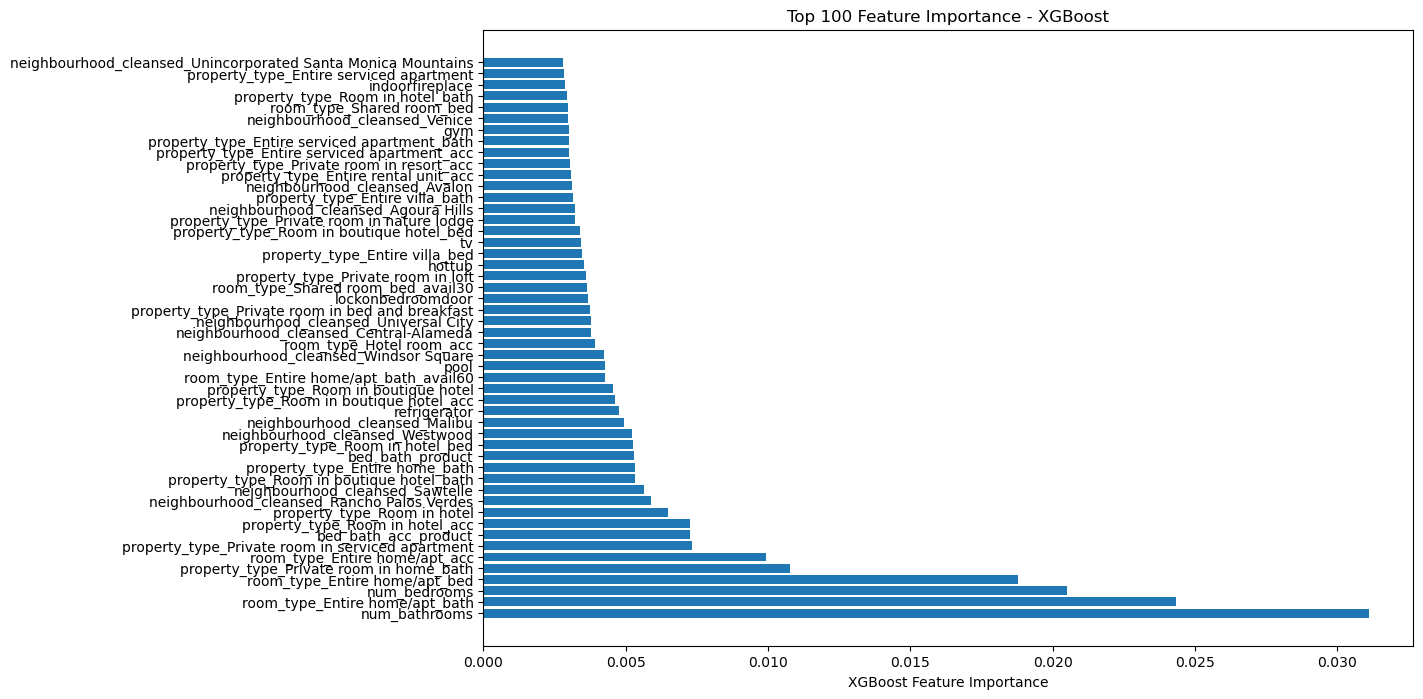

In [77]:
# Example usage:
# Assuming your dataset is in a variable called 'your_data'
cv_results, final_model, predictions = train_evaluate_xgboost(train, test)

In [78]:
param_plot = train_xgb_param_graph(train, 'learning_rate', "price")